# Fitting to a Line

Let's consider the case of fitting data to a line.  Our model has the form:

$$Y(x; a_1, a_2) = a_1 + a_2 x$$

and our fit appears as:

$$\chi^2(a_1, a_2) = \sum_{i=1}^N \frac{(a_1 + a_2 x_i - y_i)^2}{\sigma_i^2}$$

We want to minimize $\chi^2(a_1, a_2)$.

We will actually care about the [_reduced chi-square_](https://en.wikipedia.org/wiki/Reduced_chi-squared_statistic), which is scaled by the number of degrees of freedom, $N - M$, where $N$ is the number of data points and $M$ is the number of fitting parameters.

Generally we want the $\chi^2 < 1$ for a fit to be considered "good".

We start by differentiating with respect to the fit parameters and setting the derivatives to zero:

\begin{align*}
\frac{\partial \chi^2}{\partial a_1} &= 
  2 \sum_{i=1}^{N} \frac{a_1 + a_2 x_i - y_i}{\sigma_i^2} = 0 \\
\frac{\partial \chi^2}{\partial a_2} &= 
  2 \sum_{i=1}^{N} \frac{a_1 + a_2 x_i - y_i}{\sigma_i^2}  x_i= 0
\end{align*}

Separating the terms, we have:

\begin{align*}
a_1 \sum_{i=1}^N \frac{1}{\sigma_i^2} + a_2 \sum_{i=1}^N \frac{x_i}{\sigma_i^2} - \sum_{i=1}^N \frac{y_i}{\sigma_i^2} &= 0 \\
a_1 \sum_{i=1}^N \frac{x_i}{\sigma_i^2} + a_2 \sum_{i=1}^N \frac{x_i^2}{\sigma_i^2} - \sum_{i=1}^N \frac{x_i y_i}{\sigma_i^2} &= 0
\end{align*}

This is a linear system with 2 equations and 2 unknowns.

Let's define:

\begin{align*}
C &= \sum_{i=1}^N \frac{1}{\sigma_i^2} \\
S_x &= \sum_{i=1}^N \frac{x_i}{\sigma_i^2} \\
S_y &= \sum_{i=1}^N \frac{y_i}{\sigma_i^2} \\
S_{x^2} &= \sum_{i=1}^N \frac{x_i^2}{\sigma_i^2} \\
S_{xy} &= \sum_{i=1}^N \frac{x_i y_i}{\sigma_i^2}
\end{align*}

Then our system is:

\begin{align*}
a_1 C + a_2 S_x - S_y &= 0 \\
a_1 S_x + a_2 S_{x^2} - S_{xy} &= 0
\end{align*}

We can solve this easily:

$$a_1 = \frac{S_{x^2} S_y - S_x S_{xy}}{C S_{x^2} - S_x^2}$$
$$a_2 = \frac{C S_{xy} - S_x S_y}{C S_{x^2} - S_x^2}$$

## Example data

Let's make some sample data that we perturb with Gaussian-normalized noise.  We'll use the `numpy.random.randn()` function. 
(Note, in C++, you can generate random numbers in a normal distribution via [`std::normal_distribution`](https://en.cppreference.com/w/cpp/numeric/random/normal_distribution)).

Let's first see how this works.  Let's take a large number of samples and also plot a Gaussian distribution:


$$y(x) = \frac{1}{\sigma \sqrt{2\pi}}  e^{-x^2/(2 \sigma^2)}$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Text(0.5, 0, 'x')

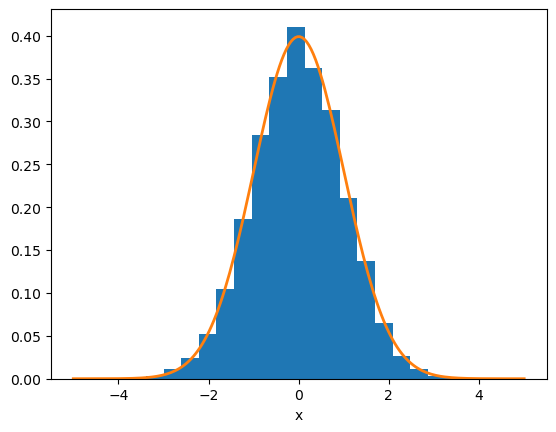

In [2]:
N = 10000
r = np.random.randn(N)

fig, ax = plt.subplots()
ax.hist(r, density=True, bins=20)

x = np.linspace(-5, 5, 200)
sigma = 1.0
ax.plot(x, np.exp(-x**2/(2*sigma**2)) / (sigma*np.sqrt(2.0*np.pi)), lw=2)
ax.set_xlabel("x")

Now we can make some _experimental data_.  This will be data that follows a line, but is perturbed by a Gaussian-normalized random number, to give it some experimental error.

In [36]:
def y_experiment(a1, a2, sigma, x):
    """ return the experimental data and error in a linear + random
    fashion; a1 is the intercept, a2 is the slope, and sigma is the
    error scale"""

    N = len(x)
    r = sigma * np.random.randn(N)

    return a1 + a2*x + r, np.abs(r)

Now we can make the data that we want to fit to.

In [37]:
# number of data points
N = 40

# one-sigma error
sigma = 25.0

# independent variable
x = np.linspace(0.0, 100, N)

y, yerr = y_experiment(10.0, 3.0, sigma, x)

Let's look at our "experiment":

<ErrorbarContainer object of 3 artists>

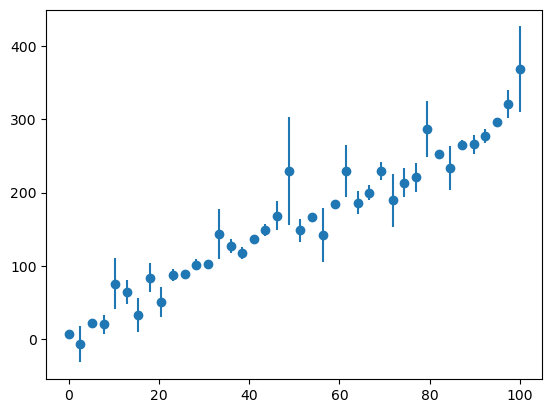

In [39]:
fig, ax = plt.subplots()
ax.errorbar(x, y, yerr=yerr, fmt="o")

Now we can write a function to do the fitting

In [40]:
def linear_regression(x, y, yerr):
    """fit data (x_i, y_i) with errors {yerr_i} to a line"""
    
    N = len(x)

    C = np.sum(1.0 / yerr**2)

    S_x = np.sum(x / yerr**2)
    S_x2 = np.sum(x * x / yerr**2)

    S_y = np.sum(y / yerr**2)
    S_xy = np.sum(x * y / yerr**2)

    a2 = (C * S_xy - S_x * S_y)/(C * S_x2 - S_x**2)
    a1 = (S_y * S_x2 - S_xy * S_x) / (C * S_x2 - S_x**2)

    chisq = np.sum((a1 + a2 * x - y)**2 / yerr**2)
    chisq /= N-2

    return a1, a2, chisq

In [41]:
a1, a2, chisq = linear_regression(x, y, yerr)

Now we can look at how well our fit does:

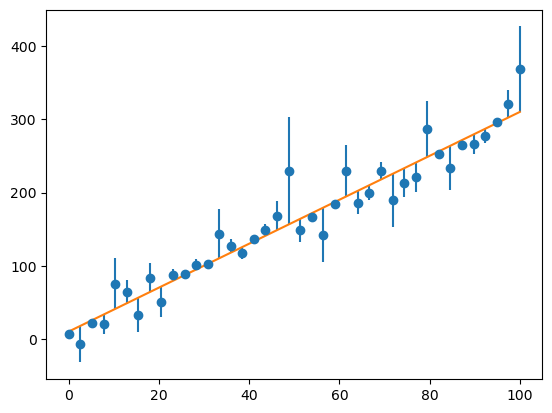

In [42]:
ax.plot(x, a1 + a2*x)
fig

## Pathologies

We need to be careful to not over-interpret a fit.  Consider the [Anscombe's quartet](https://en.wikipedia.org/wiki/Anscombe%27s_quartet).  These 4 very different datasets all have the same linear fit (to a few digits significance).